# Parkings forecasting with Prophet for Zone 1

## Initial setup

In [130]:
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from utils import (get_forecast_total_sum, cross_validate, optimize_prophet_params,
                   print_best_params)

In [131]:
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

## Data loading and cleaning

In [132]:
df = pd.read_csv("../data/parkings_small.csv") # all zones
df = df[df["zone_id"] == 1] # zone1
df['time_start'] = pd.to_datetime(df['time_start'], format="ISO8601")
df['time_end'] = pd.to_datetime(df['time_end'], format="ISO8601")

In [133]:
# clean data by removing early data days without cars
df = df[df['time_end'] > '2024-05-20']

In [134]:
rain_df = pd.read_csv('../data/artukainen_rain.csv')
rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])
rain_df = rain_df.rename(columns={"timestamp": "ds", "value": "rain"})

In [135]:
temp_df = pd.read_csv('../data/artukainen_temperature.csv')
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
temp_df = temp_df.rename(columns={"timestamp": "ds", "value": "temp"})

### Hourly time series for parking occupancy

In [136]:

# Generate hourly timestamps for each hour eg 0, 1, 2
hourly_index = pd.date_range(start=df['time_start'].min().floor('h'),
                             end=df['time_end'].max().ceil('h'),
                             freq='h')

# Initialize an empty DataFrame for hourly occupancy counts
hourly_parking = pd.DataFrame({'ds': hourly_index})

# Count active parkings in each hour
def count_active_parkings(timestamp):
    return ((df['time_start'] <= timestamp) & (df['time_end'] > timestamp)).sum()
    # time stamp is between start and end time of parking

hourly_parking['y'] = hourly_parking['ds'].apply(count_active_parkings)
hourly_parking['ds'] = hourly_parking['ds'].dt.tz_localize(None)
hourly_parking.head()

,ds,y
0,2024-05-20 00:00:00,0
1,2024-05-20 01:00:00,1
2,2024-05-20 02:00:00,1
3,2024-05-20 03:00:00,1
4,2024-05-20 04:00:00,3


### Outlier removal

In [137]:
# find the 99th percentile of the occupancy counts
percentile99 = hourly_parking['y'].quantile(0.99)
print(f'99th percentile: {percentile99}')
# remove the outliers
hourly_parking = hourly_parking[hourly_parking['y'] < percentile99]

99th percentile: 405.0


### Rain and temperature data merging

In [138]:
# Merge rain data
hourly_parking = pd.merge(hourly_parking, rain_df, on='ds', how='left')
# 3mm of rain is considered as rain
hourly_parking['rain_bool'] = hourly_parking['rain'] >= 3.0
# Merge temperature data
hourly_parking = pd.merge(hourly_parking, temp_df, on='ds', how='left')
hourly_parking.tail()

,ds,y,rain,rain_bool,temp
6251,2025-02-07 07:00:00,2,0.0,False,-0.4
6252,2025-02-07 08:00:00,2,0.0,False,0.0
6253,2025-02-07 09:00:00,2,0.0,False,0.2
6254,2025-02-07 10:00:00,2,0.0,False,0.3
6255,2025-02-07 11:00:00,0,0.0,False,0.2


## Prophet model parameter testing

In [139]:
#best_params_rmse, results_df_rmse = optimize_prophet_params(hourly_parking, target_metric='rmse')
#print_best_params(best_params_rmse, results_df_rmse)
''' results
Best Parameters:
changepoint_prior_scale: 0.01
seasonality_prior_scale: 0.1
seasonality_mode: additive
changepoint_range: 0.95
interval_width: 0.95
Best score: 65.98

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score
54                     0.01                      0.1         additive               0.95            0.95  65.977054
55                     0.01                      0.1         additive               0.95            0.99  65.977054
48                     0.01                      0.1         additive               0.80            0.95  65.988480
49                     0.01                      0.1         additive               0.80            0.99  65.988480
63                     0.01                      1.0         additive               0.95            0.99  65.990716
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.01\nseasonality_prior_scale: 0.1\nseasonality_mode: additive\nchangepoint_range: 0.95\ninterval_width: 0.95\nBest score: 65.98\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score\n54                     0.01                      0.1         additive               0.95            0.95  65.977054\n55                     0.01                      0.1         additive               0.95            0.99  65.977054\n48                     0.01                      0.1         additive               0.80            0.95  65.988480\n49                     0.01                      0.1         additive               0.80            0.99  65.988480\n63                     0.01                      1.0         additive               0.95            0.99  65.990716\n'

In [140]:
#best_params_rmse_rain, results_df_rmse_rain = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True)
#print_best_params(best_params_rmse_rain, results_df_rmse_rain)
''' results
Best Parameters:
changepoint_prior_scale: 0.01
seasonality_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.8
interval_width: 0.95
Best score: 65.99

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score
65                     0.01                     10.0         additive                0.8            0.99  65.988784
64                     0.01                     10.0         additive                0.8            0.95  65.988784
48                     0.01                      0.1         additive                0.8            0.95  65.994997
49                     0.01                      0.1         additive                0.8            0.99  65.994997
72                     0.01                    100.0         additive                0.8            0.95  65.999023
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.01\nseasonality_prior_scale: 10.0\nseasonality_mode: additive\nchangepoint_range: 0.8\ninterval_width: 0.95\nBest score: 65.99\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score\n65                     0.01                     10.0         additive                0.8            0.99  65.988784\n64                     0.01                     10.0         additive                0.8            0.95  65.988784\n48                     0.01                      0.1         additive                0.8            0.95  65.994997\n49                     0.01                      0.1         additive                0.8            0.99  65.994997\n72                     0.01                    100.0         additive                0.8            0.95  65.999023\n'

In [141]:
#best_params_rmse_temp, results_df_rmse_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_temp=True)
#print_best_params(best_params_rmse_temp, results_df_rmse_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.01
seasonality_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.85
interval_width: 0.95
Best score: 65.92

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score
66                     0.01                     10.0         additive               0.85            0.95  65.923393
67                     0.01                     10.0         additive               0.85            0.99  65.923393
68                     0.01                     10.0         additive               0.90            0.95  65.927408
69                     0.01                     10.0         additive               0.90            0.99  65.927408
58                     0.01                      1.0         additive               0.85            0.95  65.930534
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.01\nseasonality_prior_scale: 10.0\nseasonality_mode: additive\nchangepoint_range: 0.85\ninterval_width: 0.95\nBest score: 65.92\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score\n66                     0.01                     10.0         additive               0.85            0.95  65.923393\n67                     0.01                     10.0         additive               0.85            0.99  65.923393\n68                     0.01                     10.0         additive               0.90            0.95  65.927408\n69                     0.01                     10.0         additive               0.90            0.99  65.927408\n58                     0.01                      1.0         additive               0.85            0.95  65.930534\n'

In [142]:
#best_params_rmse_rain_temp, results_df_rmse_rain_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True, incl_temp=True)
#print_best_params(best_params_rmse_rain_temp, results_df_rmse_rain_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.01
seasonality_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.85
interval_width: 0.95
Best score: 65.94

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score
66                     0.01                     10.0         additive               0.85            0.95  65.941664
67                     0.01                     10.0         additive               0.85            0.99  65.941664
53                     0.01                      0.1         additive               0.90            0.99  65.942490
52                     0.01                      0.1         additive               0.90            0.95  65.942490
51                     0.01                      0.1         additive               0.85            0.99  65.944941
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.01\nseasonality_prior_scale: 10.0\nseasonality_mode: additive\nchangepoint_range: 0.85\ninterval_width: 0.95\nBest score: 65.94\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width      score\n66                     0.01                     10.0         additive               0.85            0.95  65.941664\n67                     0.01                     10.0         additive               0.85            0.99  65.941664\n53                     0.01                      0.1         additive               0.90            0.99  65.942490\n52                     0.01                      0.1         additive               0.90            0.95  65.942490\n51                     0.01                      0.1         additive               0.85            0.99  65.944941\n'

## Prophet model and forecast

In [143]:
# Function to create a model and forecast
def create_model_and_forecast(df, interval_width=0.95, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0,
                              seasonality_mode='additive', changepoint_range=0.85, rain=None, rain_bool=False, temp=None):
    m = Prophet(
        interval_width=interval_width,
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )
    m.add_country_holidays(country_name='FI')
    if rain:
        m.add_regressor('rain')
    if rain_bool:
        m.add_regressor('rain_bool')
    if temp:
        m.add_regressor('temp')
    m.fit(df)

    days = 30
    forecast_days = 24*days
    future = m.make_future_dataframe(periods=forecast_days, freq='h')
    last_date = future['ds'].max()
    start_date = last_date - pd.Timedelta(days=days-1)
    if rain:
        future = pd.merge(future, rain_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'rain'] = rain
    if rain_bool:
        if rain is None:
            future = pd.merge(future, rain_df, on='ds', how='left')       
        future['rain_bool'] = future['rain'] >= 3.0
        future.loc[future['ds'] >= start_date, 'rain_bool'] = True
    if temp:
        future = pd.merge(future, temp_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'temp'] = temp

    forecast = m.predict(future)
    forecast['yhat'] = np.round(np.maximum(forecast['yhat'], 0))
    forecast['yhat_lower'] = np.round(np.maximum(forecast['yhat_lower'], 0))
    forecast['yhat_upper'] = np.round(np.maximum(forecast['yhat_upper'], 0))
    return m, forecast

In [144]:
baseline_model, baseline_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                              changepoint_prior_scale=0.01,
                                                              seasonality_prior_scale=0.1,
                                                              seasonality_mode='additive',
                                                              changepoint_range=0.95,
                                                              rain=None, rain_bool=False, temp=None)

rain_model, rain_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                      changepoint_prior_scale=0.01,
                                                      seasonality_prior_scale=10.0,
                                                      seasonality_mode='additive',
                                                      changepoint_range=0.8,
                                                      rain=3.0, rain_bool=False, temp=None)

rain_bool_model, rain_bool_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.01,
                                                                seasonality_prior_scale=10.0,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.8,
                                                                rain=None, rain_bool=True, temp=None)

temp_params = {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive',
               'changepoint_range': 0.85, 'interval_width': 0.95}

temp_model_minus20, temp_forecast_minus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=-20)
temp_model_minus10, temp_forecast_minus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=-10)
temp_model_0, temp_forecast_0 = create_model_and_forecast(hourly_parking, **temp_params, temp=0)
temp_model_plus10, temp_forecast_plus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=10)
temp_model_plus20, temp_forecast_plus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=20)

rain_temp_model, rain_temp_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.01,
                                                                seasonality_prior_scale=10.0,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.85,
                                                                rain=3.0, rain_bool=False, temp=20)

### Total parkings in forecasts

In [145]:
# total parkings in forecast
start_date = hourly_parking['ds'].max()
end_date = start_date + pd.Timedelta(days=30)
print(f'Forecast period: {start_date} - {end_date}')

base_total = get_forecast_total_sum(baseline_forecast, start_date, end_date)
rain_total = get_forecast_total_sum(rain_forecast, start_date, end_date)
rain_bool_total = get_forecast_total_sum(rain_bool_forecast, start_date, end_date)
temp_minus20_total = get_forecast_total_sum(temp_forecast_minus20, start_date, end_date)
temp_minus10_total = get_forecast_total_sum(temp_forecast_minus10, start_date, end_date)
temp_0_total = get_forecast_total_sum(temp_forecast_0, start_date, end_date)
temp_plus10_total = get_forecast_total_sum(temp_forecast_plus10, start_date, end_date)
temp_plus20_total = get_forecast_total_sum(temp_forecast_plus20, start_date, end_date)
rain_temp_plus20_total = get_forecast_total_sum(rain_temp_forecast, start_date, end_date)
print(f'Baseline forecast cars: {base_total}')
print(f'Rain forecast cars: {rain_total}. Diff to baseline: {rain_total-base_total}')
print(f'Rain bool forecast cars: {rain_bool_total}. Diff to baseline: {rain_bool_total-base_total}')
print(f'Temp -20 forecast cars: {temp_minus20_total}. Diff to baseline: {temp_minus20_total-base_total}')
print(f'Temp -10 forecast cars: {temp_minus10_total}. Diff to baseline: {temp_minus10_total-base_total}')
print(f'Temp 0 forecast cars: {temp_0_total}. Diff to baseline: {temp_0_total-base_total}')
print(f'Temp +10 forecast cars: {temp_plus10_total}. Diff to baseline: {temp_plus10_total-base_total}')
print(f'Temp +20 forecast cars: {temp_plus20_total}. Diff to baseline: {temp_plus20_total-base_total}')
print(f'Rain & Temp +20 forecast cars: {rain_temp_plus20_total}. Diff to baseline: {rain_temp_plus20_total-base_total}')

Forecast period: 2025-02-07 11:00:00 - 2025-03-09 11:00:00
Baseline forecast cars: 104538.0
Rain forecast cars: 101248.0. Diff to baseline: -3290.0
Rain bool forecast cars: 99842.0. Diff to baseline: -4696.0
Temp -20 forecast cars: 106188.0. Diff to baseline: 1650.0
Temp -10 forecast cars: 105489.0. Diff to baseline: 951.0
Temp 0 forecast cars: 104683.0. Diff to baseline: 145.0
Temp +10 forecast cars: 104100.0. Diff to baseline: -438.0
Temp +20 forecast cars: 103408.0. Diff to baseline: -1130.0
Rain & Temp +20 forecast cars: 99286.0. Diff to baseline: -5252.0


### Forecast plotting

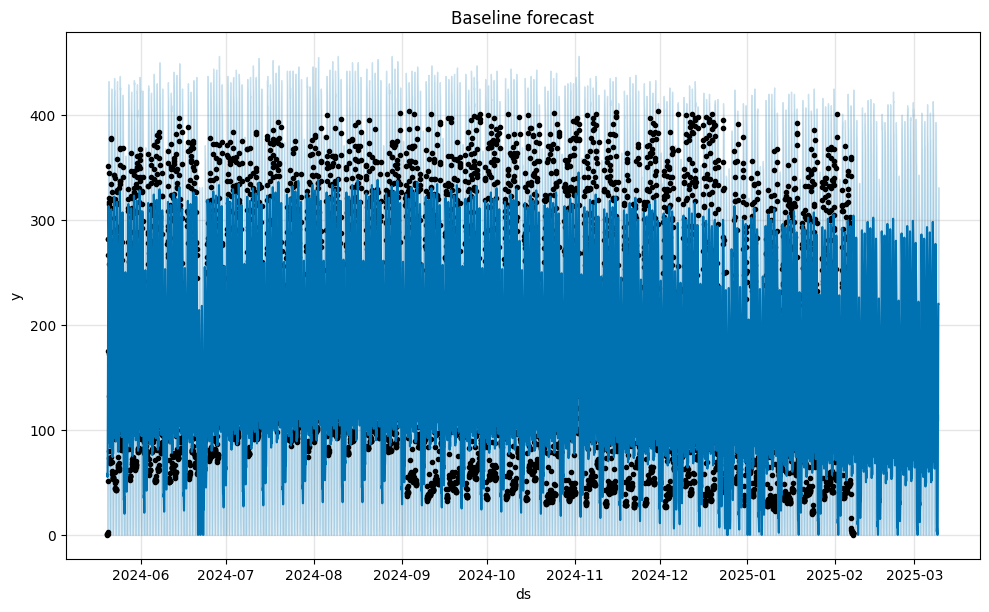

Baseline forecast components


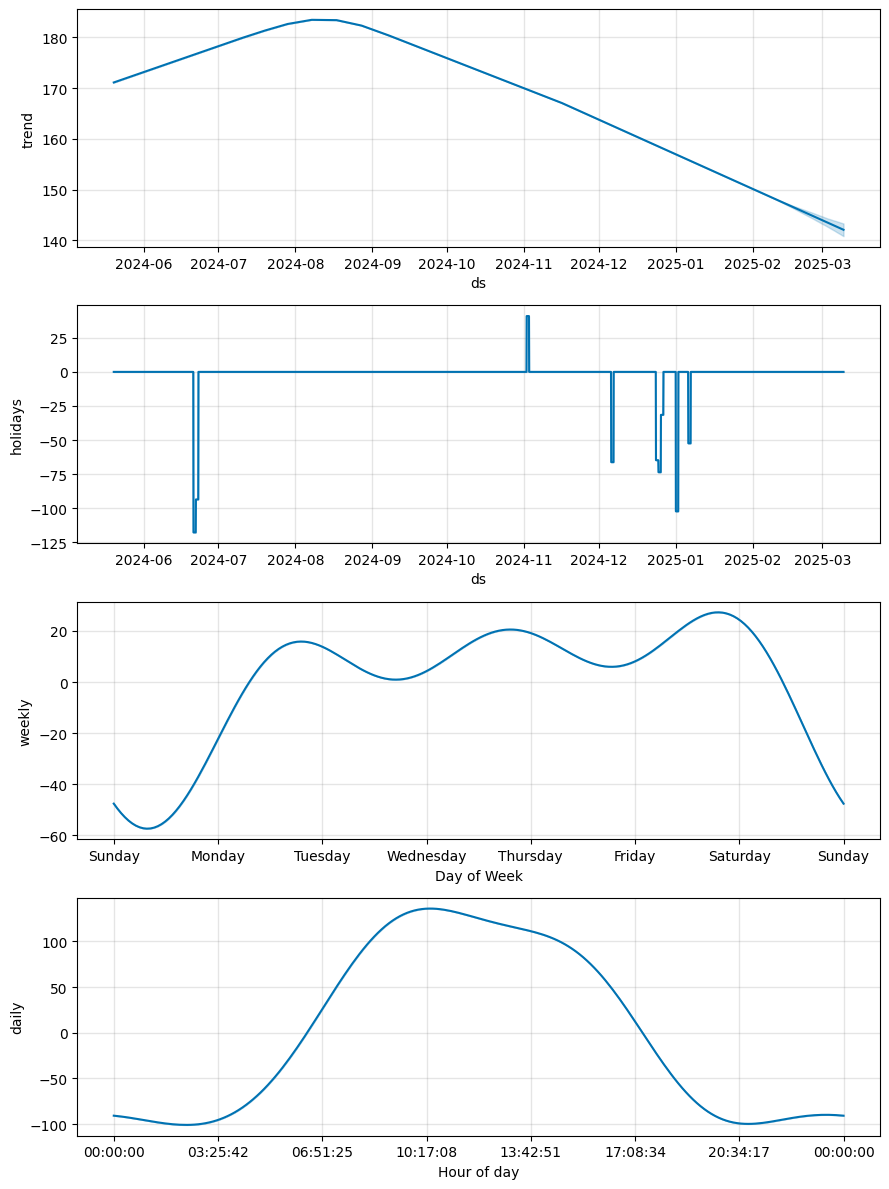

In [146]:
fig = baseline_model.plot(baseline_forecast)
plt.title('Baseline forecast')
plt.show()
fig2 = baseline_model.plot_components(baseline_forecast)
print('Baseline forecast components')
plt.show()

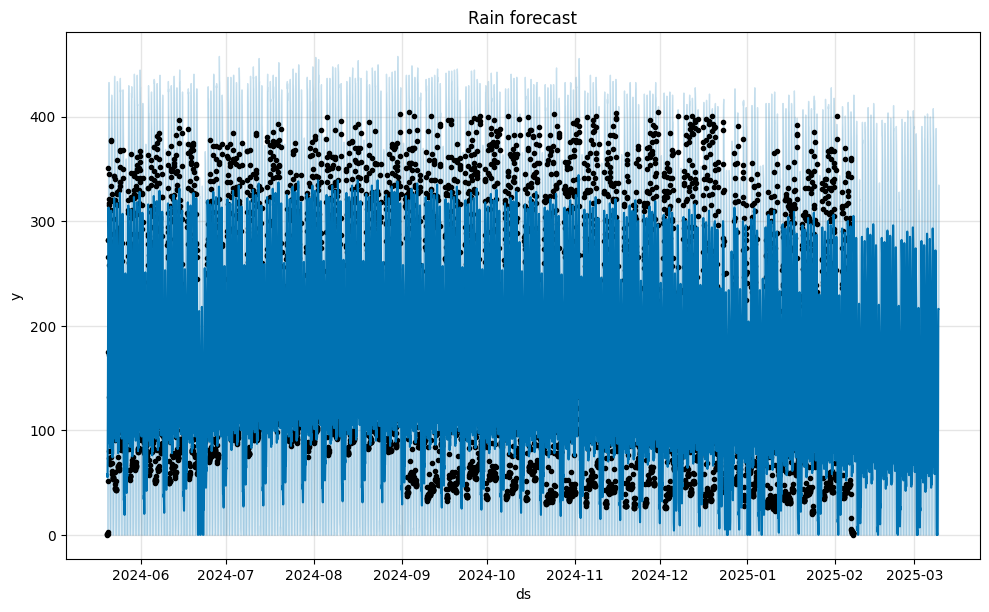

Rain forecast components


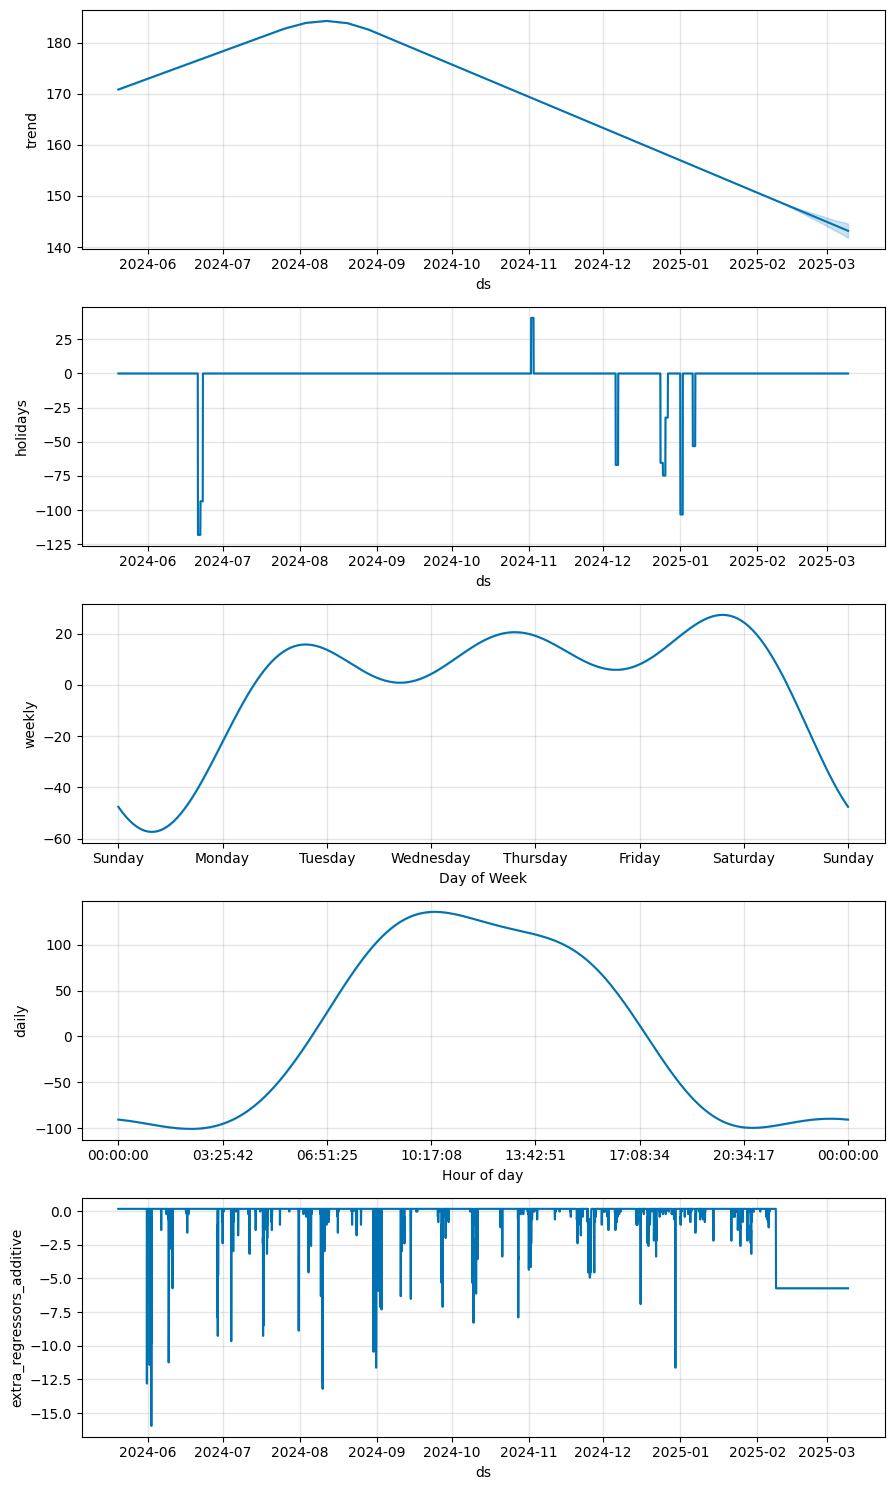

In [147]:
fig = rain_model.plot(rain_forecast)
plt.title('Rain forecast')
plt.show()
fig2 = rain_model.plot_components(rain_forecast)
print('Rain forecast components')
plt.show()

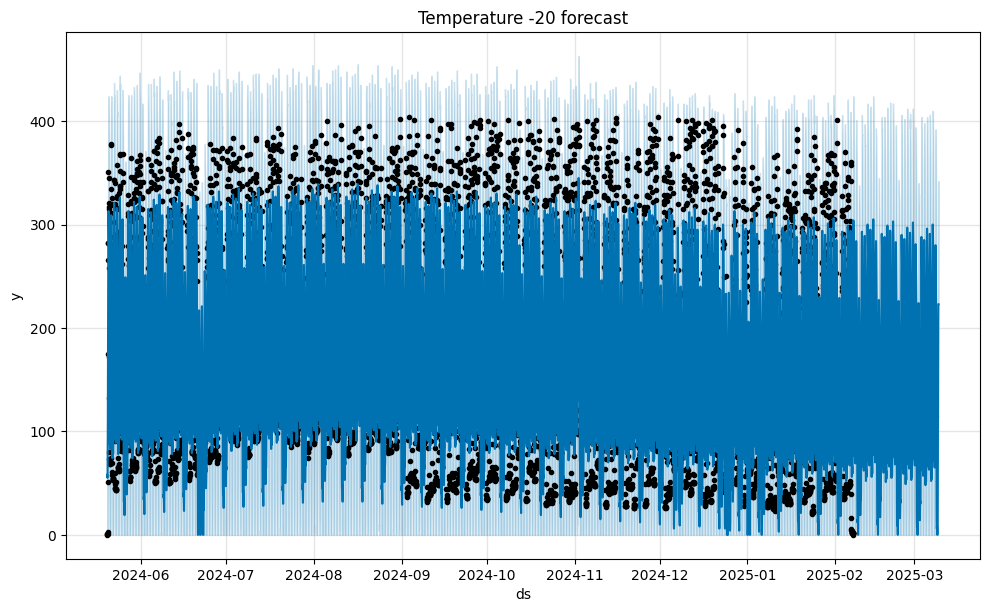

Temperature -20 forecast components


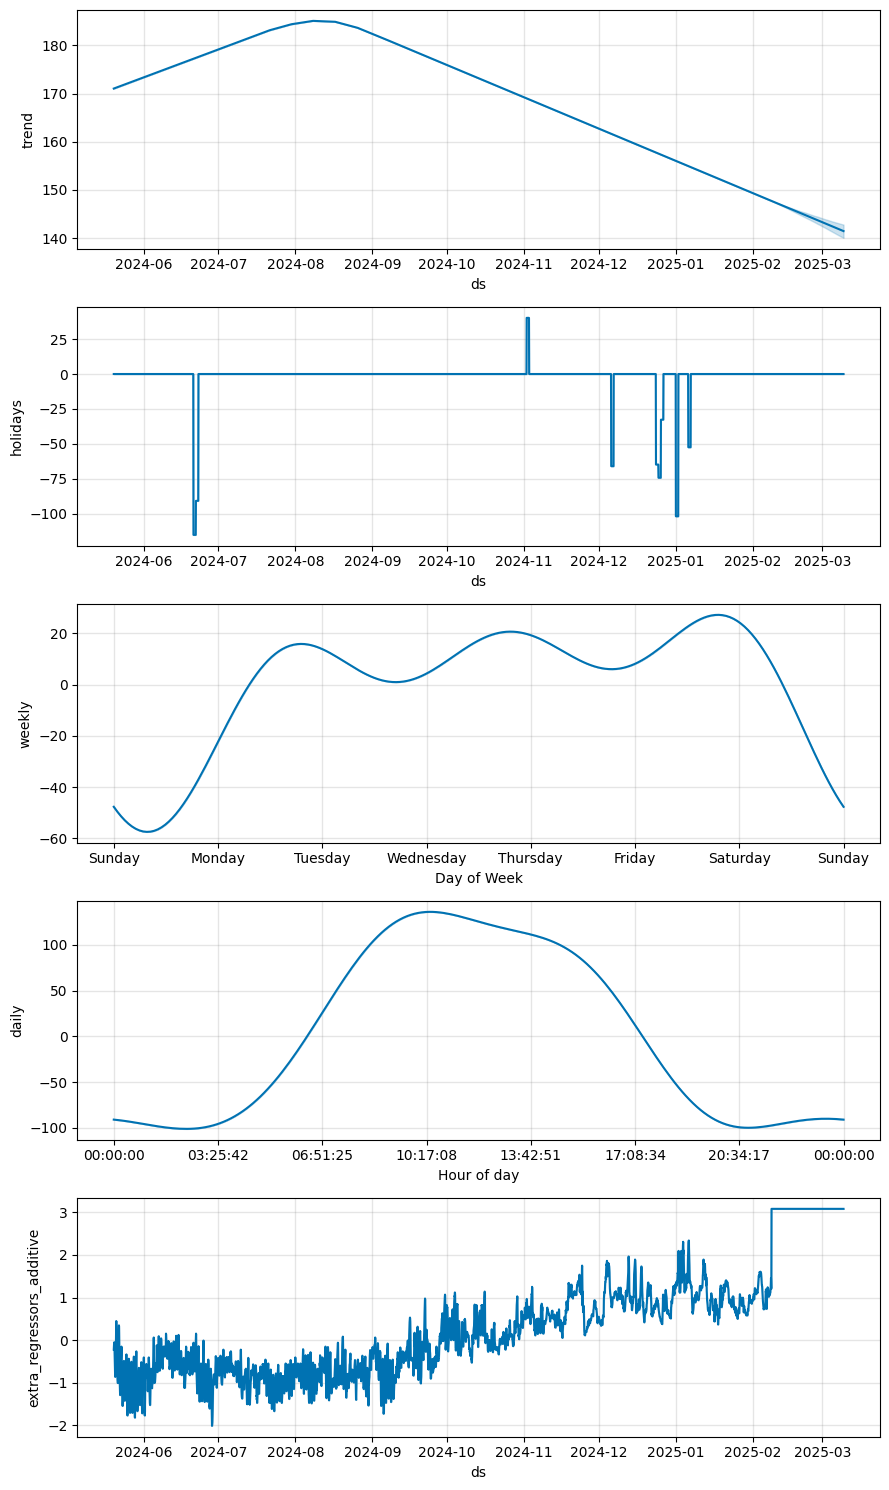

In [148]:
fig = temp_model_minus20.plot(temp_forecast_minus20)
plt.title('Temperature -20 forecast')
plt.show()
fig2 = temp_model_minus20.plot_components(temp_forecast_minus20)
print('Temperature -20 forecast components')
plt.show()

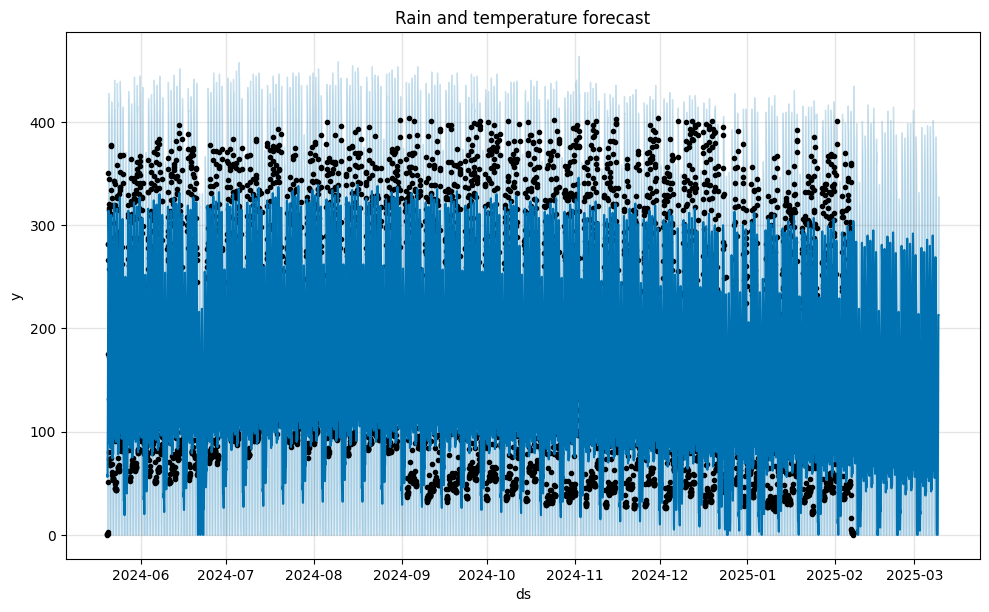

Rain and temperature forecast components


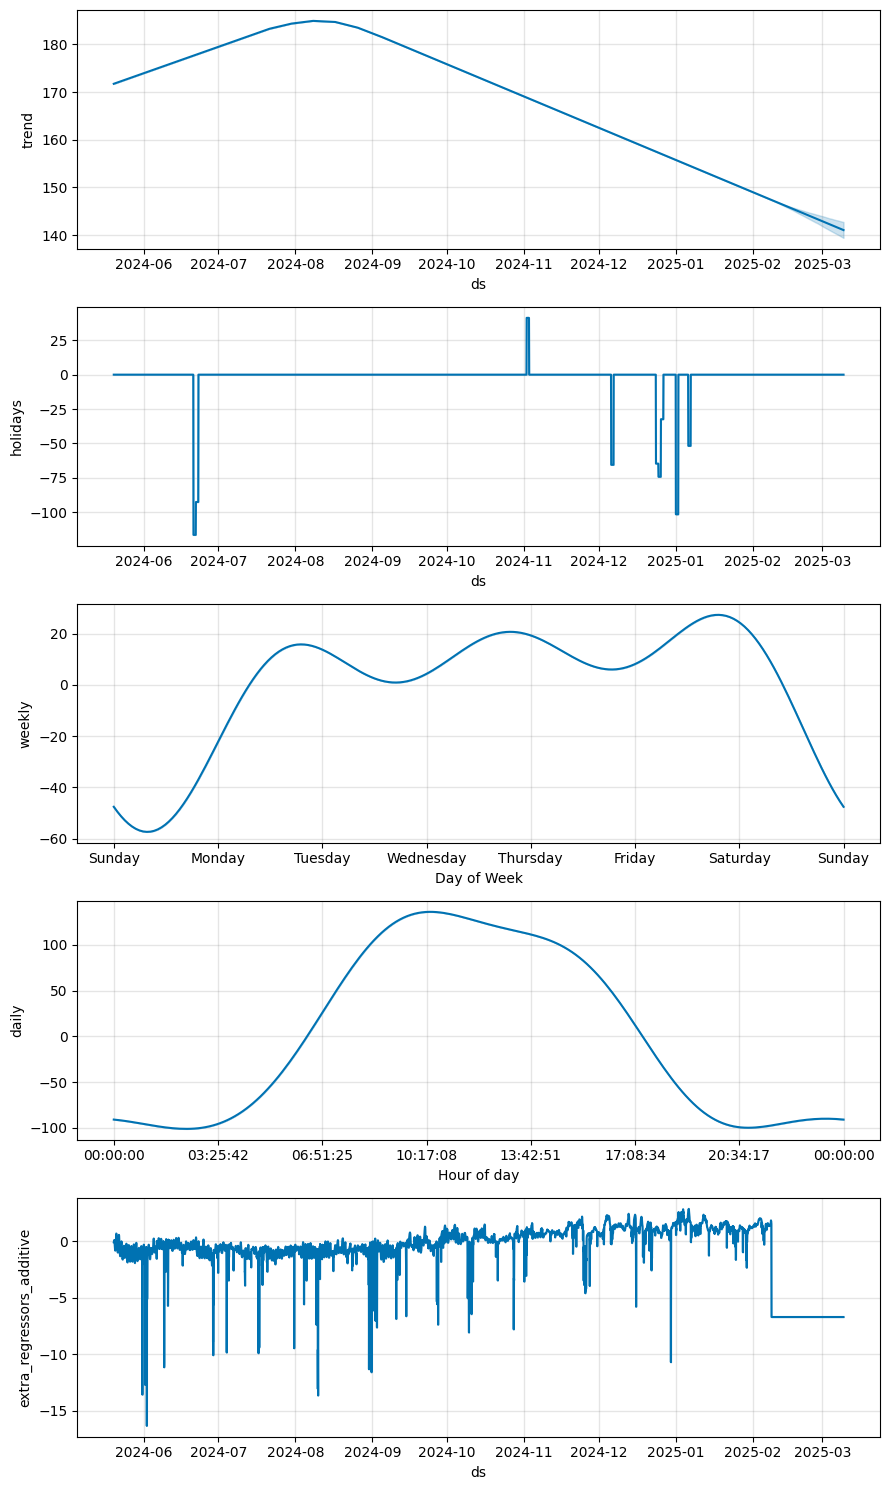

In [149]:
fig = rain_temp_model.plot(rain_temp_forecast)
plt.title('Rain and temperature forecast')
plt.show()
fig2 = rain_temp_model.plot_components(rain_temp_forecast)
print('Rain and temperature forecast components')
plt.show()

## Model performance metrics

In [150]:
base_cv = cross_validate(baseline_model, initial='120 days', period='7 days', horizon='14 days')
base_cv_p = performance_metrics(base_cv)
base_cv_p.head()
print('Baseline forecast performance metrics:')
print(base_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  3.90it/s]

Baseline forecast performance metrics:
horizon     7 days 17:30:00
mse             4427.026097
rmse              65.977054
mae               52.982511
mdape              0.402649
smape              0.463298
coverage           0.886332


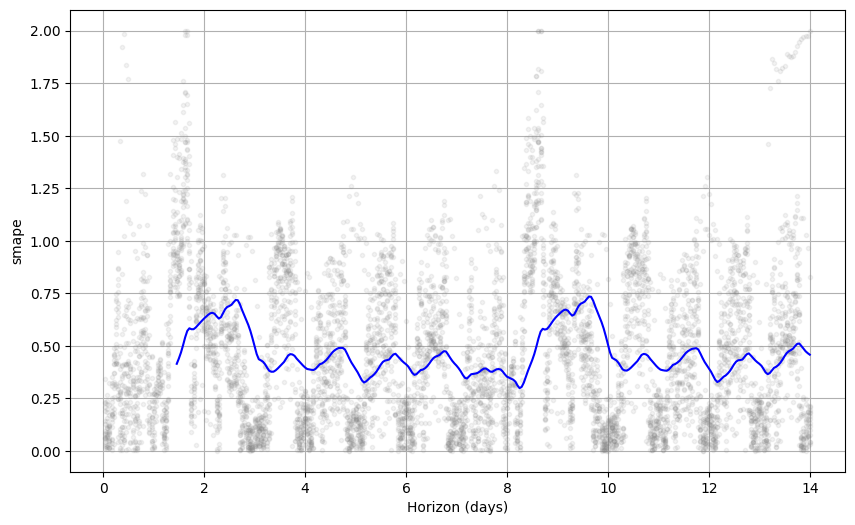

In [151]:
fig = plot_cross_validation_metric(base_cv, metric='smape')

In [152]:
rain_cv = cross_validate(rain_model, initial='120 days', period='7 days', horizon='14 days')
rain_cv_p = performance_metrics(rain_cv)
rain_cv_p.head()
print('Rain forecast performance metrics:')
print(rain_cv_p.mean().to_string())

100%|██████████| 19/19 [00:05<00:00,  3.48it/s]

Rain forecast performance metrics:
horizon     7 days 17:30:00
mse             4428.790372
rmse              65.988784
mae               52.985585
mdape              0.402819
smape              0.463565
coverage           0.884745


In [153]:
rain_bool_cv = cross_validate(rain_bool_model, initial='120 days', period='7 days', horizon='14 days')
rain_bool_cv_p = performance_metrics(rain_bool_cv)
rain_bool_cv_p.head()
print('Rain bool forecast performance metrics:')
print(rain_bool_cv_p.mean().to_string())

100%|██████████| 19/19 [00:05<00:00,  3.67it/s]

Rain bool forecast performance metrics:
horizon     7 days 17:30:00
mse              4428.72392
rmse              65.989601
mae               52.982471
mdape              0.403548
smape              0.463401
coverage           0.885304


In [154]:
temp_minus20_cv = cross_validate(temp_model_minus20, initial='120 days', period='7 days', horizon='14 days')
temp_minus20_cv_p = performance_metrics(temp_minus20_cv)
temp_minus20_cv_p.head()
print('Temp forecast performance metrics:')
print(temp_minus20_cv_p.mean().to_string())

100%|██████████| 19/19 [00:05<00:00,  3.61it/s]

Temp forecast performance metrics:
horizon     7 days 17:30:00
mse             4422.517485
rmse              65.923393
mae               52.952731
mdape              0.402886
smape              0.465491
coverage           0.884278


In [155]:
rain_temp20_cv = cross_validate(rain_temp_model, initial='120 days', period='7 days', horizon='14 days')
rain_temp20_cv_p = performance_metrics(rain_temp20_cv)
rain_temp20_cv_p.head()
print('Rain+temp forecast performance metrics:')
print(rain_temp20_cv_p.mean().to_string())

100%|██████████| 19/19 [00:05<00:00,  3.50it/s]

Rain+temp forecast performance metrics:
horizon     7 days 17:30:00
mse             4424.597663
rmse              65.941664
mae               52.970235
mdape              0.402841
smape              0.465471
coverage            0.88609
